# Gaussian Mixture Models

En este notebook, veremos el modelado de densidad con modelos de mezcla gaussiana (GMM).
En los modelos de mezcla gaussiana, describimos la densidad de los datos como
$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\quad \pi_k \geq 0\,,\quad \sum_{k=1}^K\pi_k = 1
$$

El objetivo de este notebook es comprender mejor los GMM y escribir algún código para entrenarlos utilizando el algoritmo EM. 

In [64]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.linalg as la
import matplotlib.cm as cm
from matplotlib import rc
import time
from IPython import display

import pandas as pd

%matplotlib inline

np.random.seed(42)

### Definir un GMM a partir del cual generamos datos
Configure el verdadero GMM a partir del cual generaremos datos.

In [29]:
# Seleccionamos un GMM con 3 componentes

# means
m = np.zeros((3,2))
m[0] = np.array([1.2, 0.4])
m[1] = np.array([-4.4, 1.0])
m[2] = np.array([4.1, -0.3])

# covariances
S = np.zeros((3,2,2))
S[0] = np.array([[0.8, -0.4], [-0.4, 1.0]])
S[1] = np.array([[1.2, -0.8], [-0.8, 1.0]])
S[2] = np.array([[1.2, 0.6], [0.6, 3.0]])

# mixture weights
w = np.array([0.3, 0.2, 0.5])

Genera algunos datos

In [30]:
N_split = 200 # numero total de puntos de datos por mezcla Gaussiana
N = N_split*3 # numero total de datostotal number of data points
x = []
y = []
for k in range(3):
    x_tmp, y_tmp = np.random.multivariate_normal(m[k], S[k], N_split).T 
    x = np.hstack([x, x_tmp])
    y = np.hstack([y, y_tmp])

data = np.vstack([x, y])

Visualización del conjunto de datos

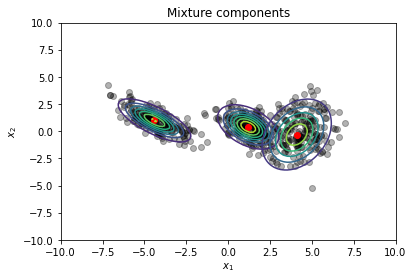

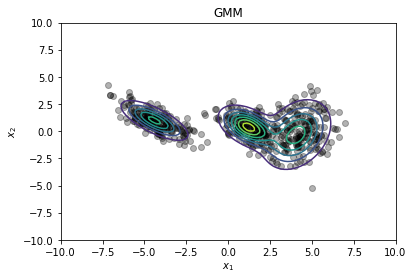

In [31]:
X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

mvn = multivariate_normal(m[0,:].ravel(), S[0,:,:])
xx = mvn.pdf(pos)

# grafica el dataset
plt.figure()
plt.title("Mixture components")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

#Grafica las componentes individuales de la GMM
plt.plot(m[:,0], m[:,1], 'or')

for k in range(3):
    mvn = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    xx = mvn.pdf(pos)
    plt.contour(X, Y, xx,  alpha = 1.0, zorder=10)
     
# grafica el GMM 
plt.figure()
plt.title("GMM")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# construye el GMM
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    gmm += w[k]*mix_comp.pdf(pos)
    
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10);

## Entrena al GMM a través de EM
### Inicializar los parámetros para EM

In [32]:
K = 3 # numero de clusters

means = np.zeros((K,2))
covs = np.zeros((K,2,2))
for k in range(K):
    means[k] = np.random.normal(size=(2,))
    covs[k] = np.eye(2)

weights = np.ones((K,1))/K
print("Vectores media iniciales (uno por fila):\n" + str(means))

Vectores media iniciales (uno por fila):
[[ 0.1252245  -0.42940554]
 [ 0.1222975   0.54329803]
 [ 0.04886007  0.04059169]]


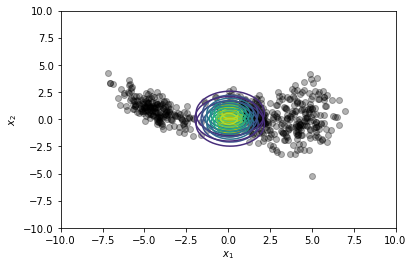

In [33]:
NLL = [] # log-likelihood del GMM
gmm_nll = 0
for k in range(K):
    gmm_nll += weights[k]*multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data.T)
NLL += [-np.sum(np.log(gmm_nll))]

plt.figure()
plt.plot(x, y, 'ko', alpha=0.3)
plt.plot(means[:,0], means[:,1], 'oy', markersize=25)

for k in range(K):
    rv = multivariate_normal(means[k,:], covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
    
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

Primero, definimos las responsabilidades (que se actualizan en el paso E), dados los parámetros del modelo $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$ como
$$
r_{nk} := \frac{\pi_k\mathcal N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)} 
          $$

Dadas las responsabilidades que acabamos de definir, podemos actualizar los parámetros del modelo en el paso M de la siguiente manera:
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
donde $$
N_k := \sum_{n=1}^N r_{nk}
$$

### EM Algorithm

<ipython-input-34-58b71a134c8c>:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Converge después de la iteración  89


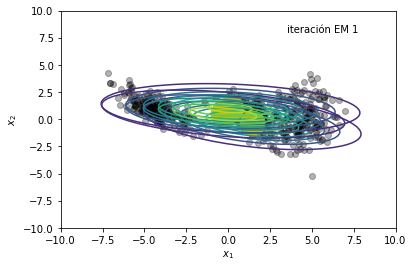

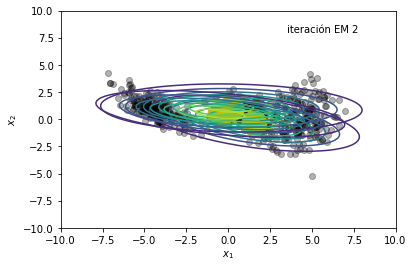

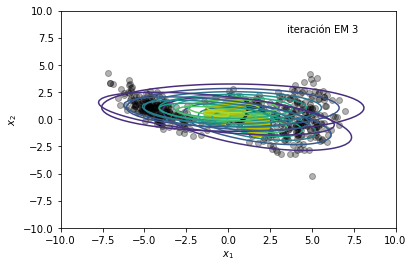

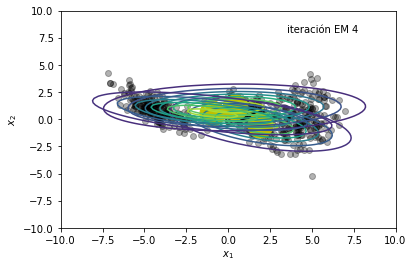

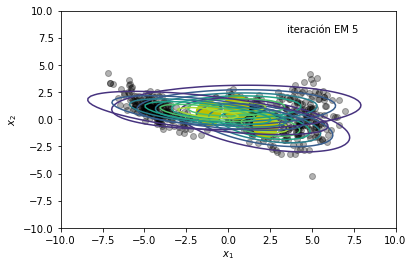

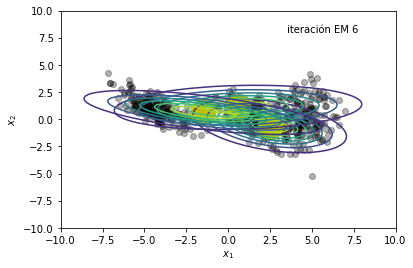

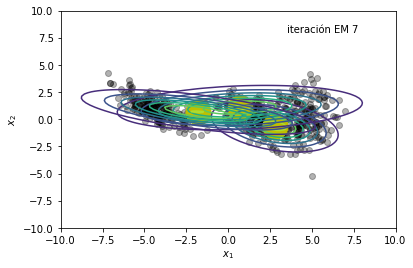

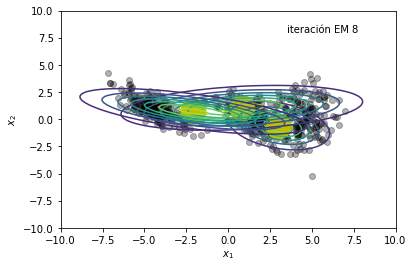

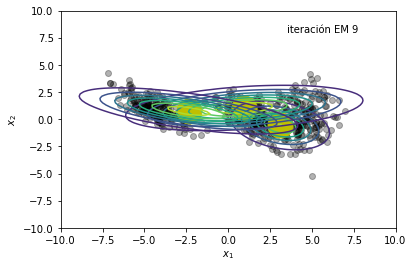

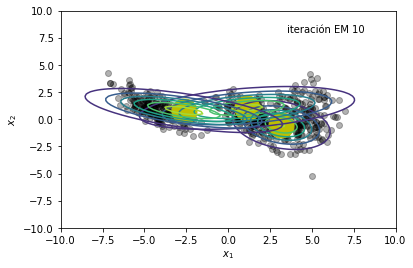

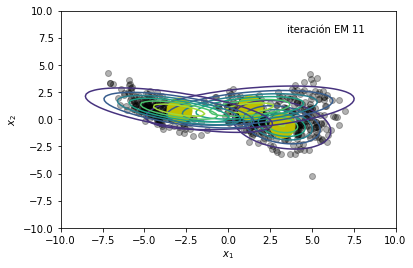

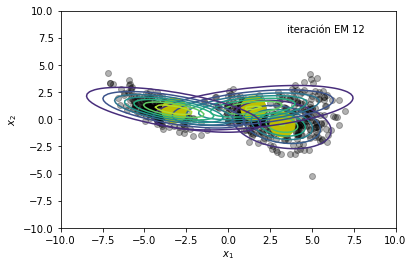

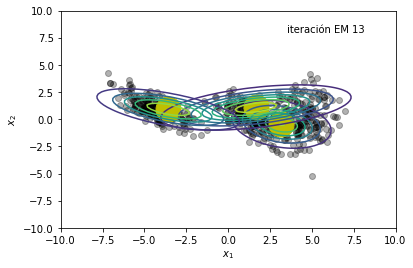

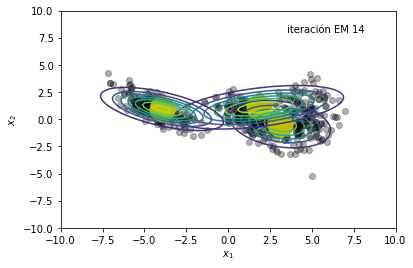

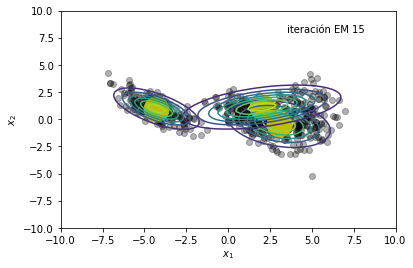

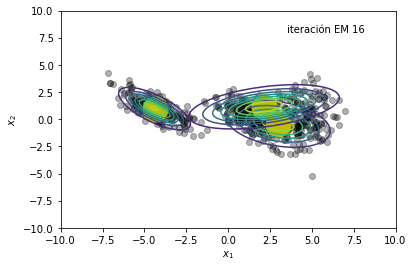

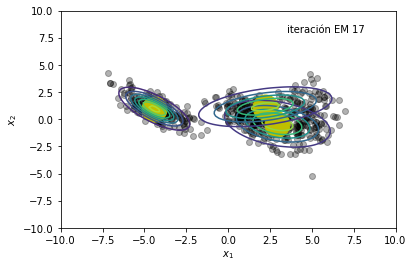

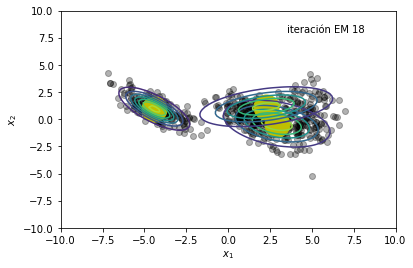

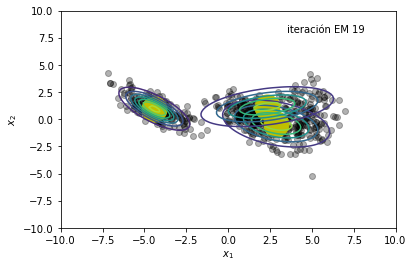

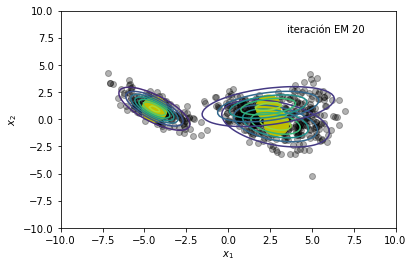

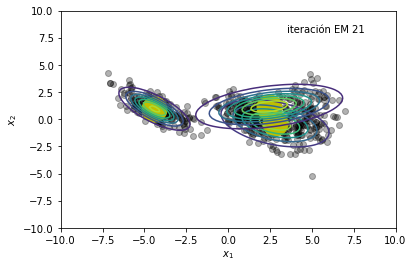

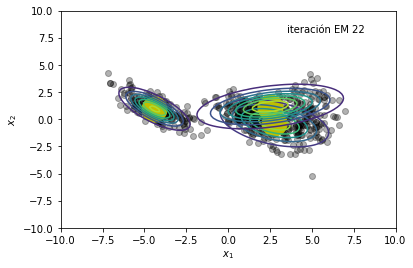

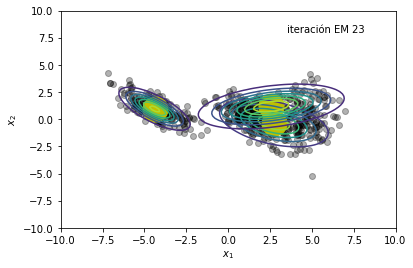

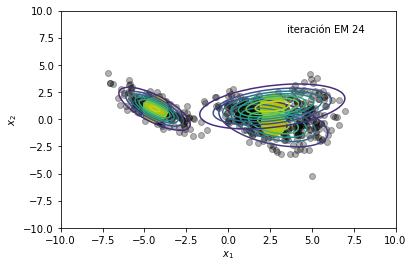

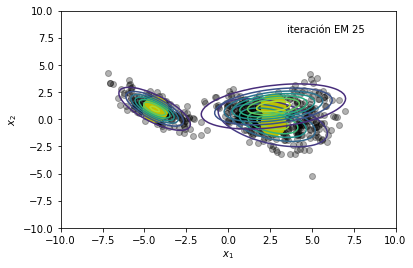

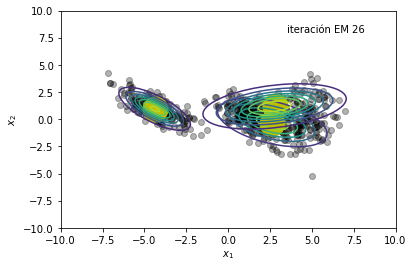

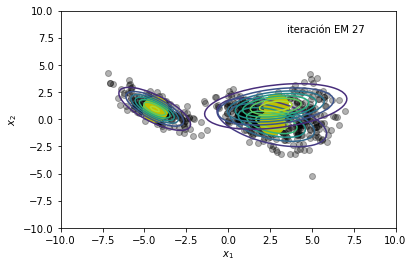

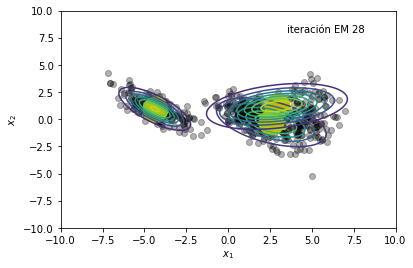

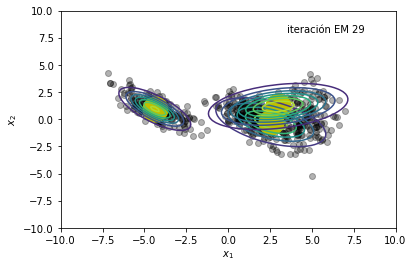

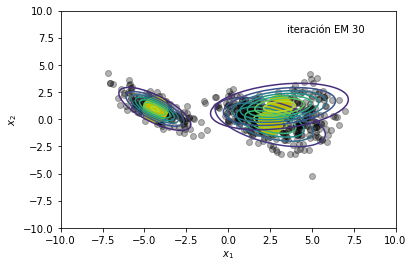

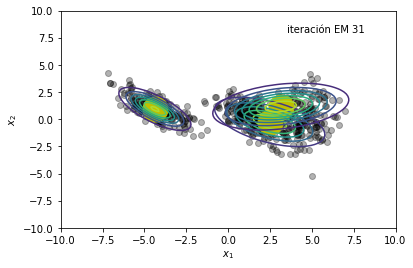

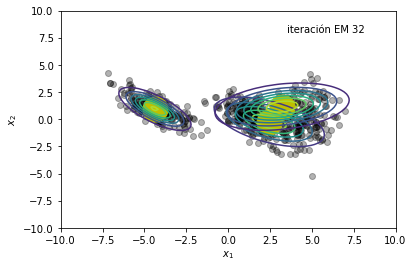

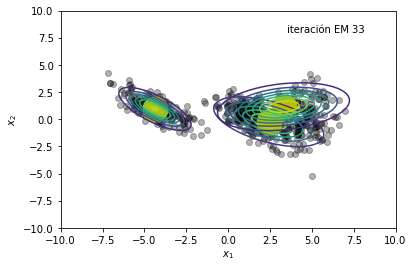

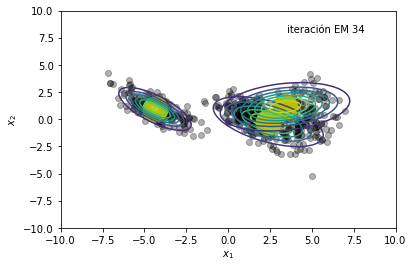

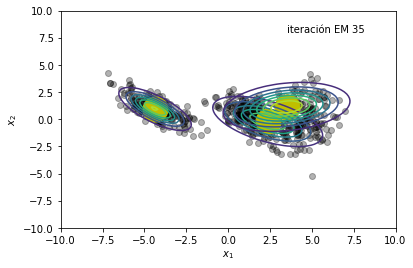

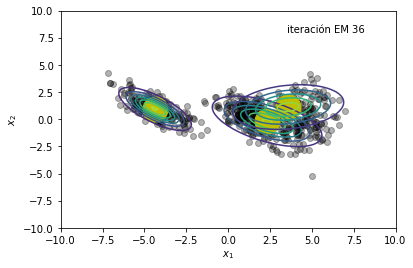

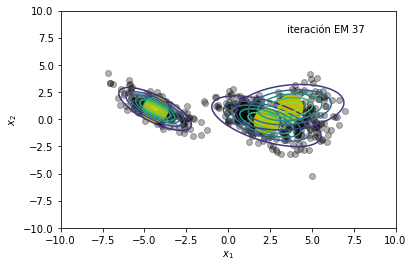

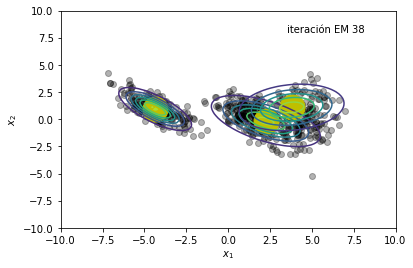

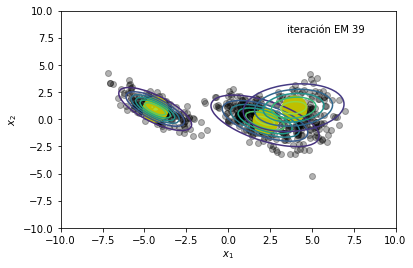

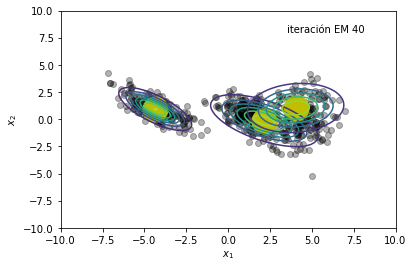

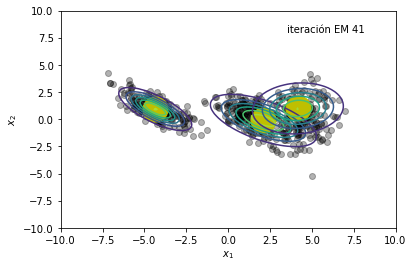

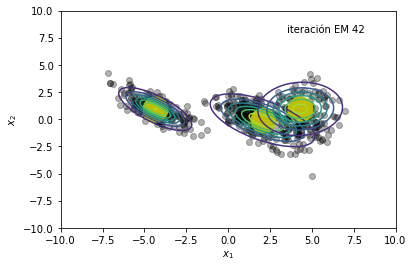

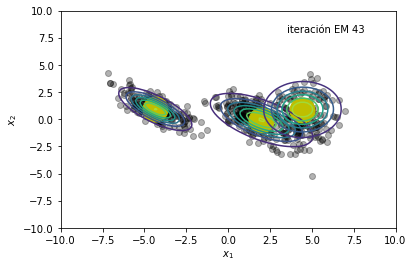

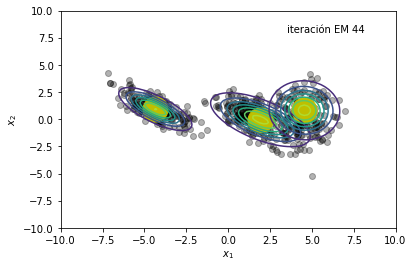

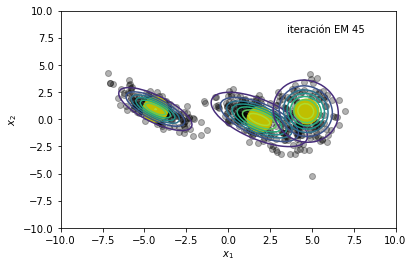

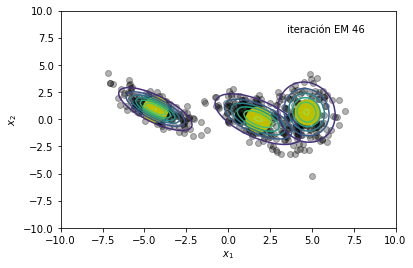

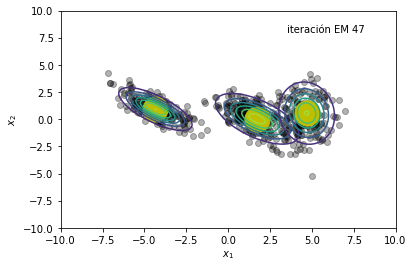

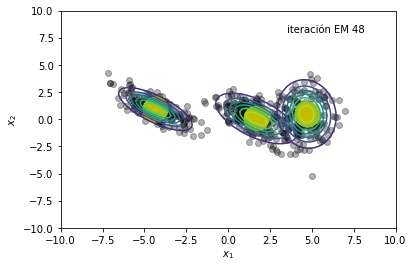

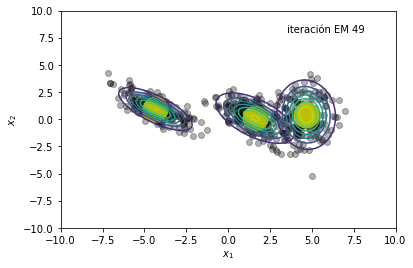

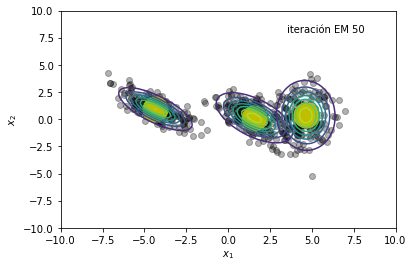

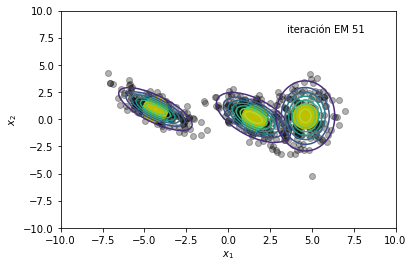

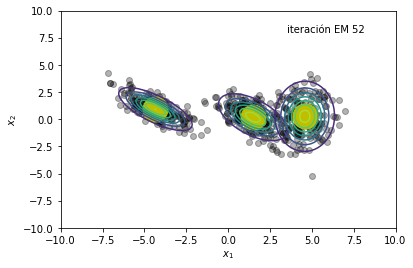

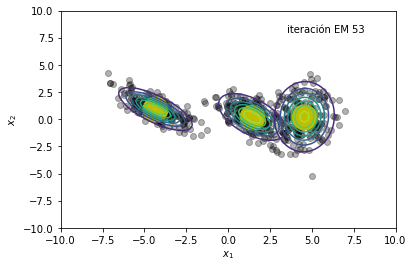

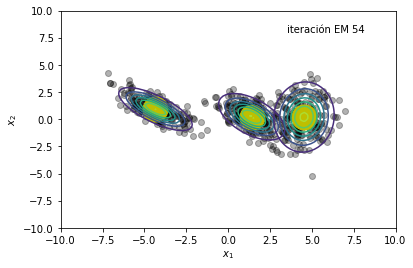

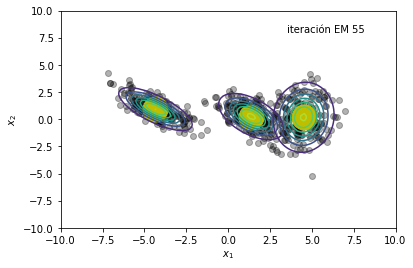

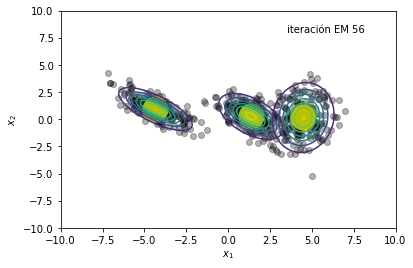

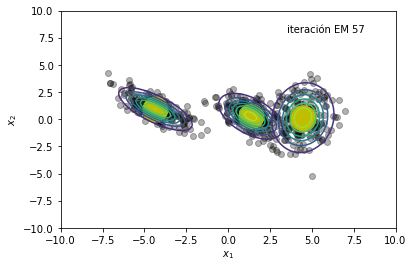

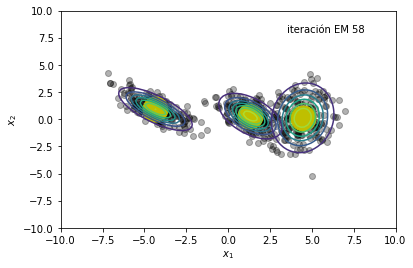

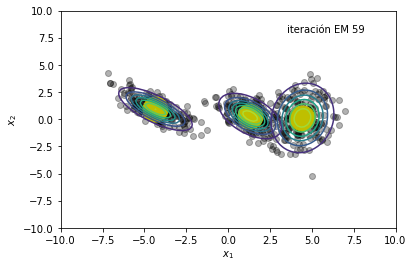

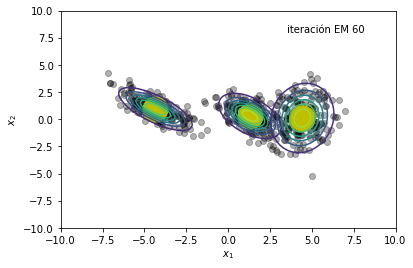

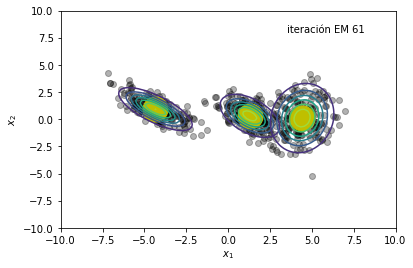

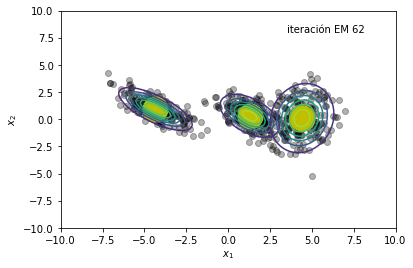

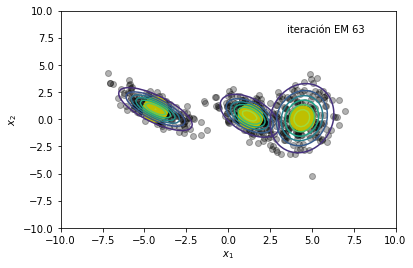

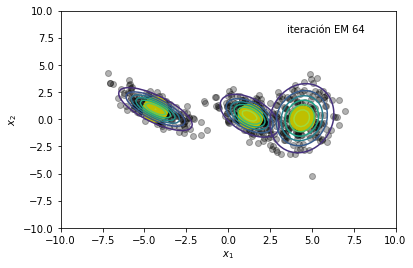

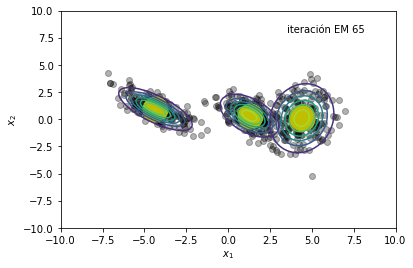

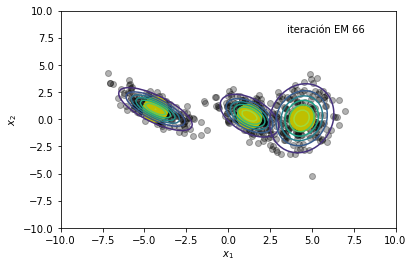

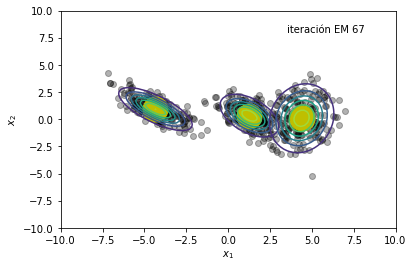

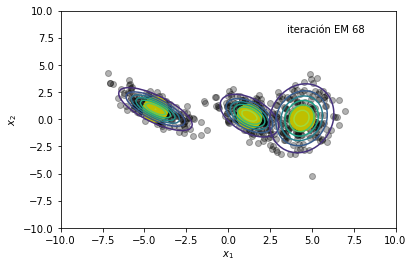

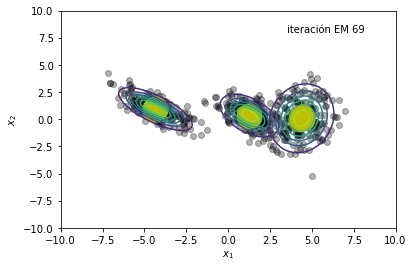

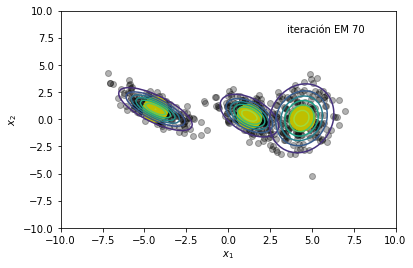

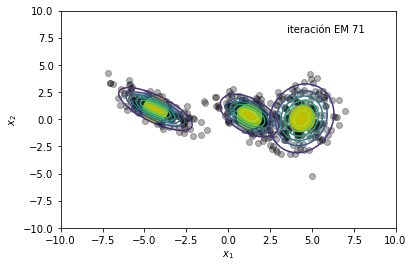

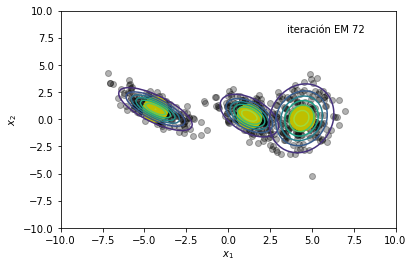

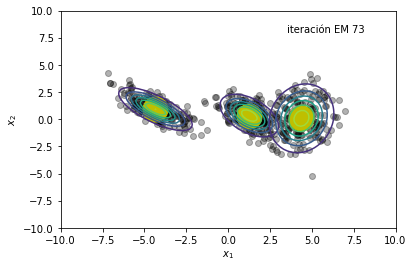

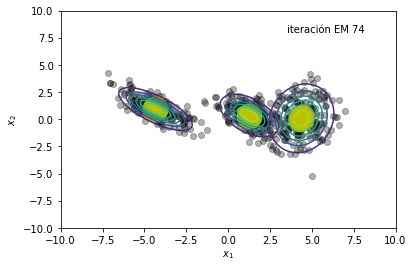

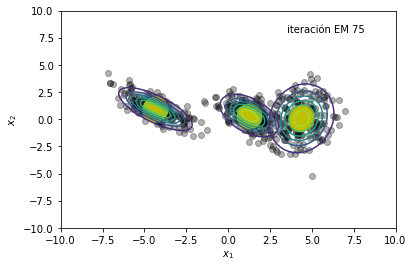

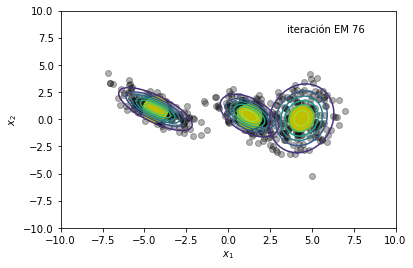

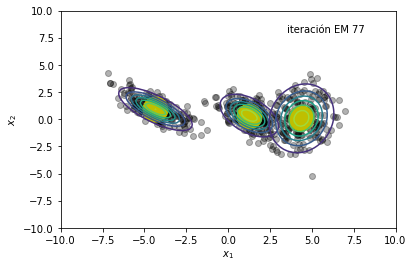

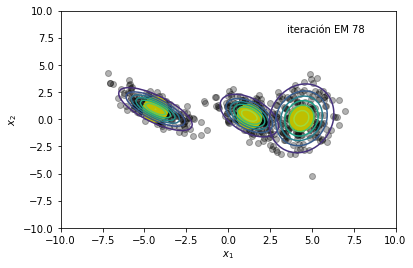

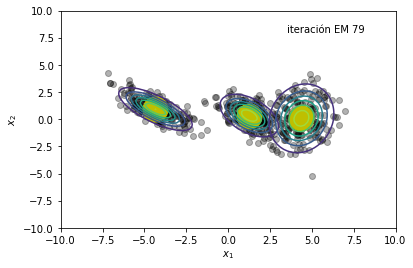

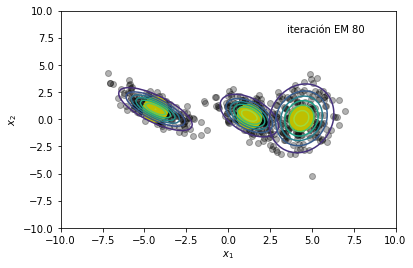

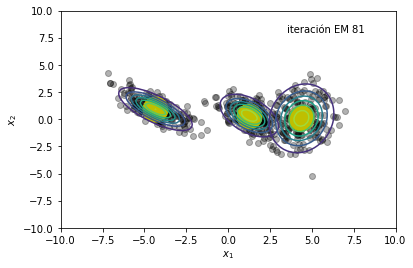

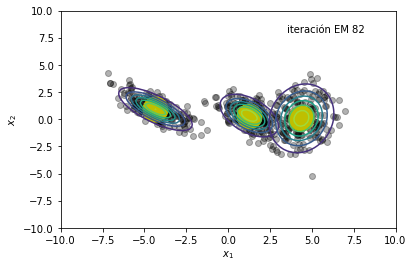

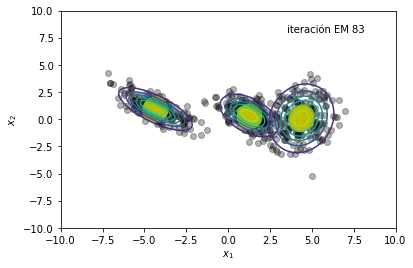

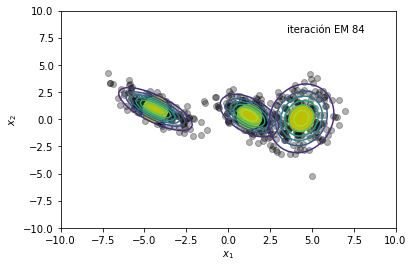

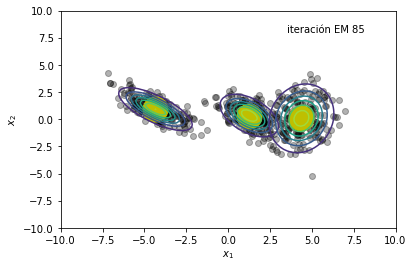

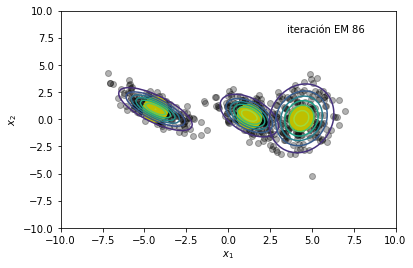

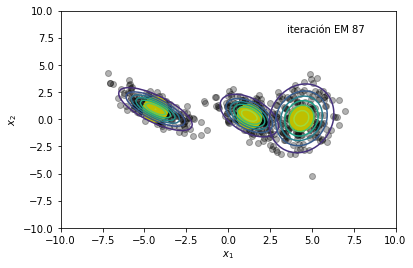

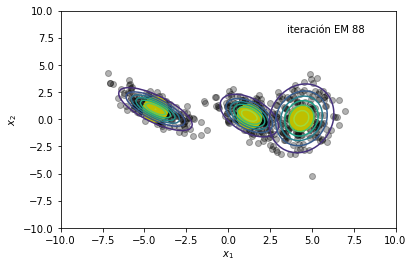

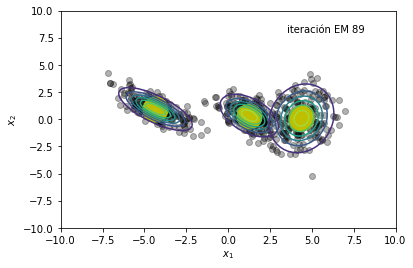

In [34]:
r = np.zeros((K,N)) # almacena las responsabilidades

for em_iter in range(100):    
    means_old = means.copy()
    
    # E-step: actualiza las responsabilidades
    for k in range(K):
        r[k] = weights[k]*multivariate_normal.pdf(
            mean=means[k,:], cov=covs[k,:,:], x=data.T)  
        
    r = r/np.sum(r, axis=0) 
        
    # M-step
    N_k = np.sum(r, axis=1)

    for k in range(K): 
        # actualiza las medias
        means[k] = np.sum(r[k]*data, axis=1)/N_k[k]
        
        # actualiza las covarianzas
        diff = data - means[k:k+1].T
        _tmp = np.sqrt(r[k:k+1])*diff
        covs[k] = np.inner(_tmp, _tmp)/N_k[k]
        
    # pesos (mixtos)
    weights = N_k/N 
    
    # log-likelihood
    gmm_nll = 0
    for k in range(K):
        gmm_nll += weights[k]*multivariate_normal.pdf(
            mean=means[k,:].ravel(), cov=covs[k,:,:], x=data.T)
    NLL += [-np.sum(np.log(gmm_nll))]
    
    plt.figure() 
    plt.plot(x, y, 'ko', alpha=0.3)
    plt.plot(means[:,0], means[:,1], 'oy', markersize=25)
    for k in range(K):
        rv = multivariate_normal(means[k,:], covs[k])
        plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
        
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.text(x=3.5, y=8, s="iteración EM "+str(em_iter+1))
    
    if la.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
        print("Converge después de la iteración ", em_iter+1)
        break

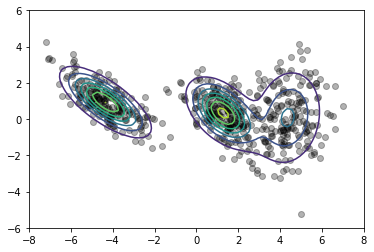

In [9]:
   
# grafica el modelo final mixto
plt.figure() 
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    gmm += weights[k]*mix_comp.pdf(pos)

plt.plot(x, y, 'ko', alpha=0.3)
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10)    
plt.xlim([-8,8]);
plt.ylim([-6,6]);

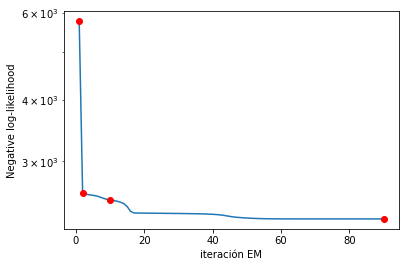

In [35]:
plt.figure()
plt.semilogy(np.linspace(1,len(NLL), len(NLL)), NLL)
plt.xlabel("iteración EM");
plt.ylabel("Negative log-likelihood");

idx = [0, 1, 9, em_iter+1]

for i in idx:
    plt.plot(i+1, NLL[i], 'or')

# Usando scikit-learn
Particularmente usando `sklearn.mixture.GaussianMixture`. La documentación completa está en este [link](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

In [52]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

## Solucionando el mismo problema anterior

In [36]:
# Ajuste del modelo con tres componentes
gmm_model = GaussianMixture(n_components=3, covariance_type="full")

gmm_model.fit(data.T)

GaussianMixture(n_components=3)

In [50]:
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm_model.score_samples(XX)
Z = Z.reshape(X.shape)

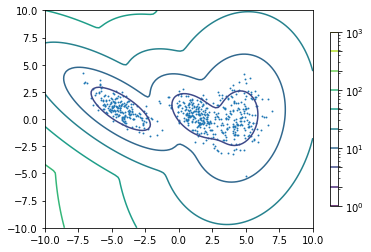

In [58]:
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8)
plt.scatter(x,y, .8);

## IRIS

In [61]:
from sklearn.datasets import load_iris
data = load_iris()
X = data['data']
y = data['target']

In [62]:
gmm_model2 = GaussianMixture(n_components=3)
gmm_model2.fit(X)

GaussianMixture(n_components=3)

In [65]:
prob = gmm_model2.predict_proba(X)
pd.DataFrame(prob)

0             1             2
0     1.000000e+00  6.062163e-35  1.011782e-43
1     1.000000e+00  2.478011e-28  9.230082e-31
2     1.000000e+00  4.012484e-30  1.027469e-35
3     1.000000e+00  2.597140e-26  1.593070e-31
4     1.000000e+00  2.543714e-35  3.785573e-46
..             ...           ...           ...
145  1.139098e-153  1.000000e+00  6.348540e-15
146  3.444701e-127  1.000000e+00  3.898823e-09
147  1.324157e-136  9.999983e-01  1.707149e-06
148  1.155281e-158  1.000000e+00  2.146843e-10
149  2.527290e-121  9.979206e-01  2.079391e-03

[150 rows x 3 columns]

In [82]:
y_pred = gmm_model2.predict(X)

pd.set_option("display.max_rows", None, "display.max_columns", None)

pd.DataFrame(np.c_[y,y_pred], columns=['y', 'y_pred'])

y  y_pred
0    0       0
1    0       0
2    0       0
3    0       0
4    0       0
5    0       0
6    0       0
7    0       0
8    0       0
9    0       0
10   0       0
11   0       0
12   0       0
13   0       0
14   0       0
15   0       0
16   0       0
17   0       0
18   0       0
19   0       0
20   0       0
21   0       0
22   0       0
23   0       0
24   0       0
25   0       0
26   0       0
27   0       0
28   0       0
29   0       0
30   0       0
31   0       0
32   0       0
33   0       0
34   0       0
35   0       0
36   0       0
37   0       0
38   0       0
39   0       0
40   0       0
41   0       0
42   0       0
43   0       0
44   0       0
45   0       0
46   0       0
47   0       0
48   0       0
49   0       0
50   1       2
51   1       2
52   1       2
53   1       2
54   1       2
55   1       2
56   1       2
57   1       2
58   1       2
59   1       2
60   1       2
61   1       2
62   1       2
63   1       2
64   1       2
65   1       2
66   1       2
67   1       2
68   1       1
69   1       2
70   1       1
71   1       2
72   1       1
73   1       2
74   1       2
75   1       2
76   1       2
77   1       1
78   1       2
79   1       2
80   1       2
81   1       2
82   1       2
83   1       1
84   1       2
85   1       2
86   1       2
87   1       2
88   1       2
89   1       2
90   1       2
91   1       2
92   1       2
93   1       2
94   1       2
95   1       2
96   1       2
97   1       2
98   1       2
99   1       2
100  2       1
101  2       1
102  2       1
103  2       1
104  2       1
105  2       1
106  2       1
107  2       1
108  2       1
109  2       1
110  2       1
111  2       1
112  2       1
113  2       1
114  2       1
115  2       1
116  2       1
117  2       1
118  2       1
119  2       1
120  2       1
121  2       1
122  2       1
123  2       1
124  2       1
125  2       1
126  2       1
127  2       1
128  2       1
129  2       1
130  2       1
131  2       1
132  2       1
133  2       1
134  2       1
135  2       1
136  2       1
137  2       1
138  2       1
139  2       1
140  2       1
141  2       1
142  2       1
143  2       1
144  2       1
145  2       1
146  2       1
147  2       1
148  2       1
149  2       1

# Ejercicio

La siguiente imagen es un linfocito normal de la sangre periférica

In [91]:
from PIL import Image

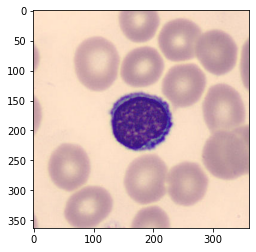

In [94]:
image = Image.open("linfo.jpg")
plt.imshow(image);

In [93]:
# Convierte la imagen a un array de numpy

im = np.asarray(image)
print(im.shape)

(363, 360, 3)


Utilice un modelo GMM para segmentar la imagen del linfocito en tres ( o cuatro) regiones. El resultado debe ser tres (o cuatro) imágenes correspondientes a las probabilidades posteriores de las agrupaciones generadas con el modelo de GMM.

Sugerencia. Recuerde que cada pixel de la imagen está compuesta por tres valores R,G,B. Para convertir la imagen a un conjunto de datos de n filas x 3 columnas, utilice `np.reshape()` y de ahí podra usar el modelo GMM. Posteriormente, también deberar usar el reshape para volver cada columna de las probabilidades en una imagen de escala de grises con un tamaño de 363x360 (note que solo es una matriz, porque es de escala de grises).